In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from neuraldistributions.models import transforms
from neuraldistributions.datasets import static

from multiprocessing import Pool

import os
device = "cuda"

dataport not available, will only be able to load data locally


In [3]:
import numpy as np
import torch

from neuraldistributions.datasets import mouse_static_loaders, extract_data_key
from neuraldistributions.models import poisson, zig, flowfa, ziffa, flowfa_ident
from neuraldistributions.trainers import base_trainer
from neuraldistributions.utility import get_loglikelihood

from torch.distributions import LowRankMultivariateNormal

from tqdm import tqdm

In [4]:
random_seed=42
dataset_dir = "../project/data"
datasets = [
    "static_edited_dsampled.zip",
]
scan_id = [2, 1]
dataset_paths = [f"{dataset_dir}/{dataset}" for dataset in datasets]
areas = [["V1", "LM"]]
neurons_ns = [1000, 907]

In [5]:
dataset_index = 0
dataset_path = dataset_paths[dataset_index]
data_key = extract_data_key(dataset_path)
area = areas[dataset_index]
neurons_n = neurons_ns[dataset_index]

dataset_config = {
    "paths": [dataset_path],
    "seed": random_seed,
    "batch_size": 64,
    "area": area,
    "neurons_n": neurons_n,
    "normalize_images": True,
    "normalize_neurons": True,
    "return_more": True,
    "device": device,
    "shuffle_train": True,
    "return_real_responses": False
}

dataloaders = mouse_static_loaders(**dataset_config)

100%|██████████| 5994/5994 [00:00<00:00, 294984.67it/s]


In [6]:
model = torch.load("./models/FlowFA-Ident")
original = torch.load("./models/FlowFA")


In [7]:
# get name of dataloader
index_name_of_dataloader = next(iter(dataloaders["train"]))

# get indices of repeated samples
indexes = np.arange(len(dataloaders["image_ids"][index_name_of_dataloader]["test"]))
u, inv = (np.unique(dataloaders["image_ids"][index_name_of_dataloader]["test"], return_inverse=True))

# get the indices of the first ten repeated samples
img_indexes = indexes[inv == inv[0]]
print(img_indexes)

[0 1 2 3 4 5 6 7 8 9]


642
473
696
252
797
904
921
385
61


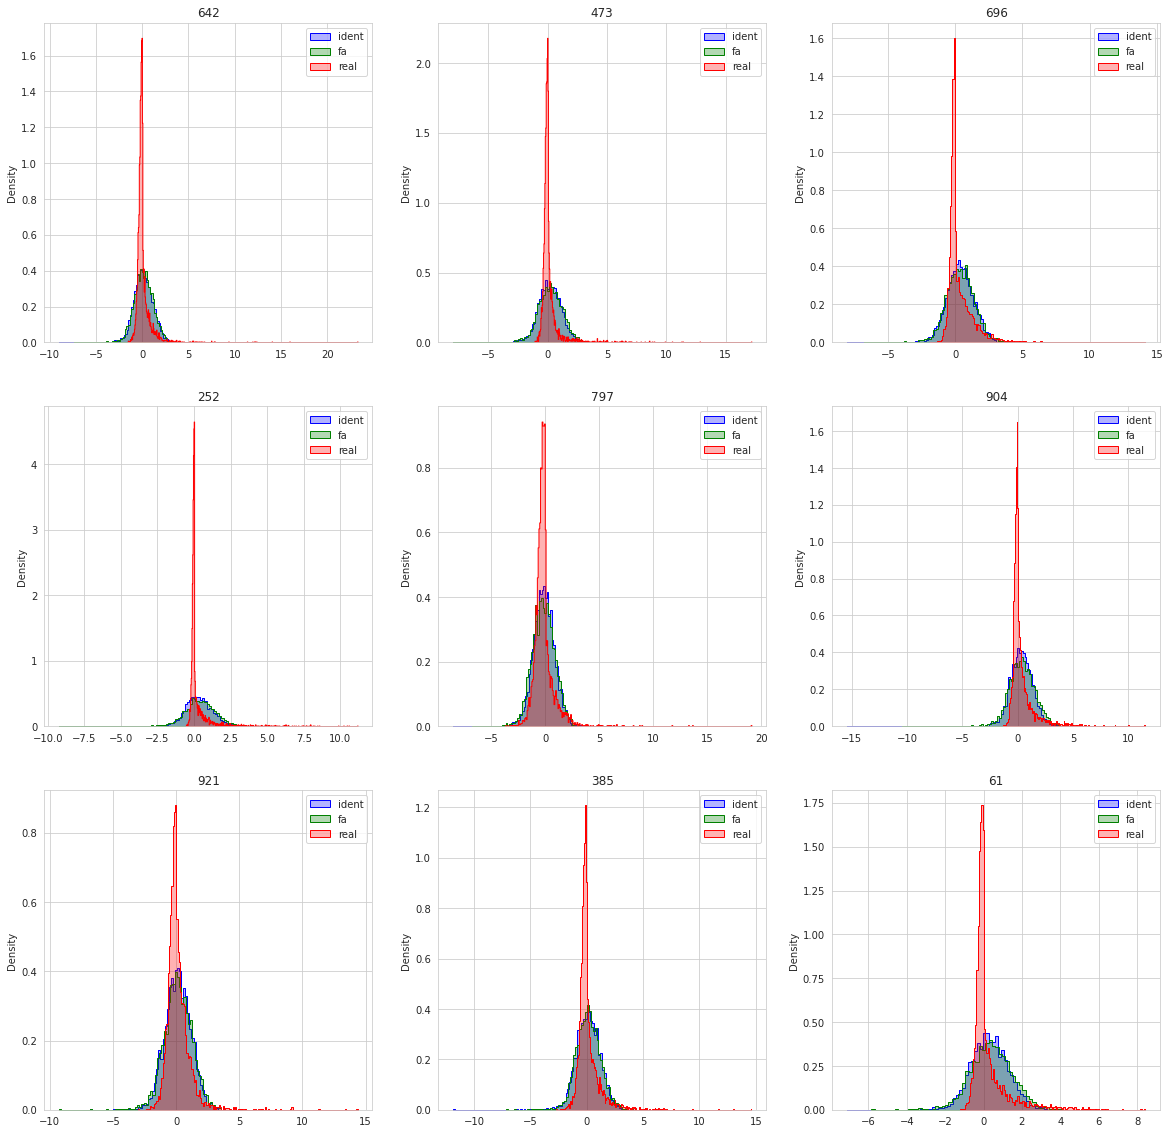

In [22]:
from neuralpredictors.training import LongCycler

random_neurons = np.random.choice(1000,9)
random_values_ident = []
random_values_fa = []
random_values_fa = []
real_values = []
for batch_idx, (data_key, batch) in enumerate(LongCycler(dataloaders['train'])):
    mu_ident = model.forward(*batch, data_key=None).to("cpu")
    normal_ident = torch.distributions.multivariate_normal.MultivariateNormal(mu_ident, torch.eye(1000).to(mu_ident.device))
    
    mu_fa = original.forward(*batch, data_key=None)
    C, psi_diag = original.C_and_psi_diag
    normal_fa = LowRankMultivariateNormal(mu_fa, C.T, psi_diag)
    
    if batch_idx != 69:
        random_values_ident.append(model.sample_transform.inv(normal_ident.sample([10]).to("cuda"))[0].detach().cpu().numpy())
        random_values_fa.append(original.sample_transform.inv(normal_fa.sample([10]))[0].detach().cpu().numpy())
        real_values.append(batch[1].detach().cpu().numpy())
        
random_values_ident = torch.tensor(random_values_ident).reshape(-1,1000)
random_values_fa = torch.tensor(random_values_fa).reshape(-1,1000)
real_values = torch.tensor(real_values).reshape(-1,1000)

fig, ax = plt.subplots(3,3, figsize=(20,20))
for i, neuron in enumerate(random_neurons):
    print(neuron)
    sns.histplot(random_values_ident[:,neuron].detach().cpu(), ax=ax[i//3][i%3], stat="density", element="step", color="blue", alpha=0.3, label="ident")
    sns.histplot(random_values_fa[:,neuron].detach().cpu(), ax=ax[i//3][i%3], stat="density", element="step", color="green", alpha=0.3, label="fa")
    sns.histplot(real_values[:,neuron].detach().cpu(), ax=ax[i//3][i%3], stat="density", element="step", color="red", alpha=0.3,label="real" )
    ax[i//3][i%3].set_title(str(neuron))
    ax[i//3][i%3].legend()
plt.show()
fig.savefig("images/FlowFA-Fit-Test.pdf", format="pdf",dpi=300)

461
920
142
389
631
681
156
334
860


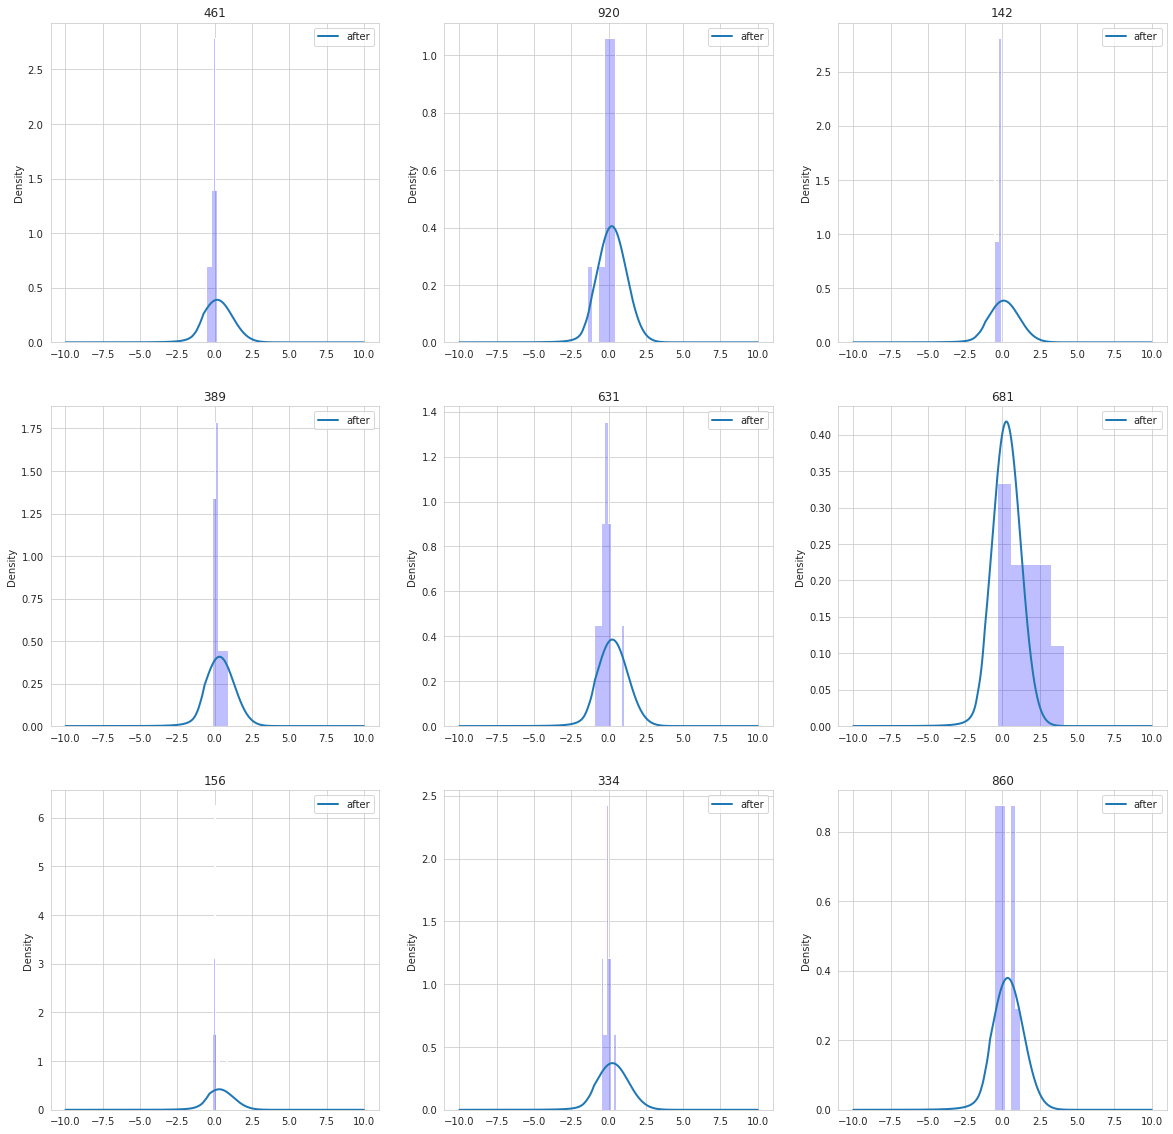

In [15]:
mu = model.forward(*batch, data_key=None).to("cpu")
points = torch.linspace(-10,10, 1000).to(device)
# get transformed targets (for log likelihood) and logdet
transformed_targets, logdet = model.sample_transform(points.unsqueeze(0).T.repeat_interleave(1000,dim=1).to(device))
batch = (next(iter(dataloaders["test"][index_name_of_dataloader])))
inputs, targets = batch[:2]
# create plot for each neuron
fig, ax = plt.subplots(3,3, figsize=(20,20))
for i, neuron in enumerate(random_neurons):
    print(neuron) 
    # create normal distribution (gaussian with mu of the neuron and std=1)
    normal = torch.distributions.normal.Normal(mu[img_indexes[0]][neuron], torch.tensor([1.0]))
    
    # get log likelihood with log prob and log det, and get likelihood
    values = normal.log_prob(transformed_targets.detach().to("cpu"))
    
    ax[i//3][i%3].plot(points.detach().cpu(), torch.exp(values.detach()[:,neuron] + logdet.detach().to("cpu")[:,neuron]), label="after", linewidth=2)
    ax[i//3][i%3].set_title(str(neuron))
    ax[i//3][i%3].legend()
    sns.histplot(targets[img_indexes][:,neuron].detach().cpu(), ax=ax[i//3][i%3], stat="density", element="step", color="blue", alpha=0.25, edgecolor=None)
    #ax[i//3][i%3].hist(targets[img_indexes][:,neuron].detach().cpu().numpy(), color="blue", density=True)

plt.show()

233
31
288
637
578
541
113
203
28


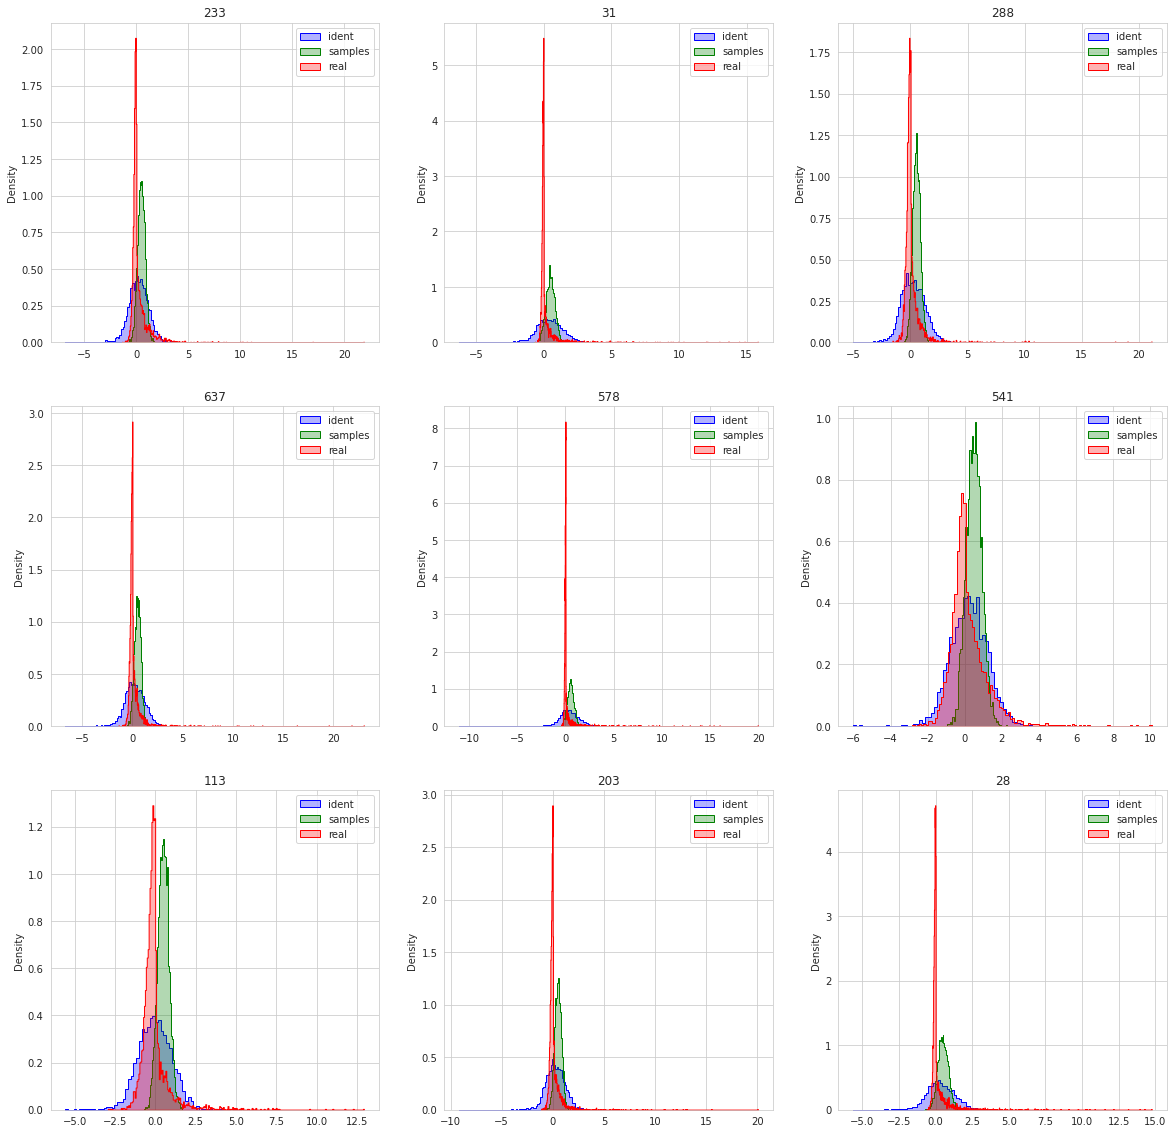

In [21]:
from neuralpredictors.training import LongCycler

random_neurons = np.random.choice(1000,9)
random_values_ident = []
random_values_fa = []
real_values = []
for batch_idx, (data_key, batch) in enumerate(LongCycler(dataloaders['train'])):
    mu_ident = model.forward(*batch, data_key=None).to("cpu")
    normal_ident = torch.distributions.multivariate_normal.MultivariateNormal(mu_ident, torch.eye(1000).to(mu_ident.device))
    
    if batch_idx != 69:
        random_values_ident.append(model.sample_transform.inv(normal_ident.sample([10]).to("cuda"))[0].detach().cpu().numpy())
        random_values_fa.append(normal_fa.sample([10])[0].detach().cpu().numpy())
        real_values.append(batch[1].detach().cpu().numpy())
        
random_values_ident = torch.tensor(random_values_ident).reshape(-1,1000)
random_values_fa = torch.tensor(random_values_fa).reshape(-1,1000)
real_values = torch.tensor(real_values).reshape(-1,1000)

fig, ax = plt.subplots(3,3, figsize=(20,20))
for i, neuron in enumerate(random_neurons):
    print(neuron)
    sns.histplot(random_values_ident[:,neuron].detach().cpu(), ax=ax[i//3][i%3], stat="density", element="step", color="blue", alpha=0.3, label="ident")
    sns.histplot(random_values_fa[:,neuron].detach().cpu(), ax=ax[i//3][i%3], stat="density", element="step", color="green", alpha=0.3, label="samples")
    sns.histplot(real_values[:,neuron].detach().cpu(), ax=ax[i//3][i%3], stat="density", element="step", color="red", alpha=0.3,label="real" )
    ax[i//3][i%3].set_title(str(neuron))
    ax[i//3][i%3].legend()
plt.show()
fig.savefig("images/FlowFA-Fit-Test.pdf", format="pdf",dpi=300)